<a href="https://colab.research.google.com/github/mennasherif14/AI-Project/blob/main/Model_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Celebrity Face Classification - EfficientNetB0 Model

**Project**: Recognize top 10 celebrities from LFW dataset using transfer learning.

**Dataset**: Processed LFW (top 10 classes: George_W_Bush, Colin_Powell, Tony_Blair, Donald_Rumsfeld, Gerhard_Schroeder, Ariel_Sharon, Hugo_Chavez, Junichiro_Koizumi, Jean_Chretien, John_Ashcroft)

**Model**: EfficientNetB0 (transfer learning + fine-tuning)

**Goal**: High accuracy, Grad-CAM visualizations, ready for comparison with ResNet50/VGG16 and GUI integration.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# **Dataset Paths & Clean to Top-10 Classes**

In [3]:

import os, shutil, random

SOURCE_DIR = "/content/drive/MyDrive/celebrity_face_project/processed/aligned/lfw"
DEST_DIR   = "/content/drive/MyDrive/celebrity_face_project/processed"

TOP_CELEBS = [
    "George_W_Bush",
    "Colin_Powell",
    "Tony_Blair",
    "Donald_Rumsfeld",
    "Gerhard_Schroeder",
    "Ariel_Sharon",
    "Hugo_Chavez",
    "Junichiro_Koizumi",
    "Jean_Chretien",
    "John_Ashcroft"
]

IMG_EXT = (".jpg", ".jpeg", ".png")

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(DEST_DIR, split), exist_ok=True)

for person in TOP_CELEBS:
    person_dir = os.path.join(SOURCE_DIR, person)
    images = [f for f in os.listdir(person_dir) if f.lower().endswith(IMG_EXT)]

    random.shuffle(images)
    n = len(images)

    train_imgs = images[:int(0.7 * n)]
    val_imgs   = images[int(0.7 * n):int(0.85 * n)]
    test_imgs  = images[int(0.85 * n):]

    split_map = {
        "train": train_imgs,
        "val": val_imgs,
        "test": test_imgs
    }

    for split, imgs in split_map.items():
        target_dir = os.path.join(DEST_DIR, split, person)
        os.makedirs(target_dir, exist_ok=True)

        for img in imgs:
            shutil.copy(
                os.path.join(person_dir, img),
                os.path.join(target_dir, img)
            )

print("Train:", os.listdir(os.path.join(DEST_DIR, "train")))
print("Val:", os.listdir(os.path.join(DEST_DIR, "val")))
print("Test:", os.listdir(os.path.join(DEST_DIR, "test")))



Train: ['Junichiro_Koizumi', 'Jean_Chretien', 'John_Ashcroft', 'George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Ariel_Sharon', 'Hugo_Chavez']
Val: ['Jean_Chretien', 'John_Ashcroft', 'George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Ariel_Sharon', 'Hugo_Chavez', 'Junichiro_Koizumi']
Test: ['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Ariel_Sharon', 'Hugo_Chavez', 'Junichiro_Koizumi', 'Jean_Chretien', 'John_Ashcroft']


# **Data Generators**

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32

DATA_DIR = "/content/drive/MyDrive/celebrity_face_project/processed"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes
print(f"Classes: {NUM_CLASSES} | Train: {train_gen.samples} | Val: {val_gen.samples} | Test: {test_gen.samples}")

Found 1413 images belonging to 10 classes.
Found 566 images belonging to 10 classes.
Found 573 images belonging to 10 classes.
Classes: 10 | Train: 1413 | Val: 566 | Test: 573


# **Class Weights**

In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

# Map index → weight
class_weights = dict(enumerate(class_weights_array))

# Map index → class name
index_to_class = {v: k for k, v in train_gen.class_indices.items()}

# Print class weights with class names
class_weights_named = {index_to_class[k]: v for k, v in class_weights.items()}
print("Class weights:", class_weights_named)


Class weights: {'Ariel_Sharon': np.float64(1.835064935064935), 'Colin_Powell': np.float64(0.6143478260869565), 'Donald_Rumsfeld': np.float64(1.2181034482758621), 'George_W_Bush': np.float64(0.2759765625), 'Gerhard_Schroeder': np.float64(1.3330188679245283), 'Hugo_Chavez': np.float64(2.0779411764705884), 'Jean_Chretien': np.float64(2.7173076923076924), 'John_Ashcroft': np.float64(2.7705882352941176), 'Junichiro_Koizumi': np.float64(2.3949152542372882), 'Tony_Blair': np.float64(0.9950704225352113)}


In [7]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
model_path = "/content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5"
os.makedirs(os.path.dirname(model_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# Phase 1: Train top layers
history1 = model.fit(train_gen, validation_data=val_gen, epochs=20, class_weight=class_weights, callbacks=callbacks)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1570 - loss: 2.3959
Epoch 1: val_accuracy improved from -inf to 0.16608, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - accuracy: 0.1573 - loss: 2.3954 - val_accuracy: 0.1661 - val_loss: 2.1324 - learning_rate: 0.0010
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.2268 - loss: 2.1371
Epoch 2: val_accuracy improved from 0.16608 to 0.25442, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 565ms/step - accuracy: 0.2275 - loss: 2.1361 - val_accuracy: 0.2544 - val_loss: 2.1026 - learning_rate: 0.0010
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.2967 - loss: 1.9956
Epoch 3: val_accuracy improved from 0.25442 to 0.31272, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 588ms/step - accuracy: 0.2974 - loss: 1.9943 - val_accuracy: 0.3127 - val_loss: 1.9526 - learning_rate: 0.0010
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.3998 - loss: 1.8536
Epoch 4: val_accuracy improved from 0.31272 to 0.45230, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 551ms/step - accuracy: 0.4005 - loss: 1.8524 - val_accuracy: 0.4523 - val_loss: 1.8405 - learning_rate: 0.0010
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4528 - loss: 1.7302
Epoch 5: val_accuracy improved from 0.45230 to 0.51060, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 537ms/step - accuracy: 0.4531 - loss: 1.7297 - val_accuracy: 0.5106 - val_loss: 1.7684 - learning_rate: 0.0010
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.5275 - loss: 1.6196
Epoch 6: val_accuracy did not improve from 0.51060
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 497ms/step - accuracy: 0.5272 - loss: 1.6189 - val_accuracy: 0.4452 - val_loss: 1.7944 - learning_rate: 0.0010
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5440 - loss: 1.4931
Epoch 7: val_accuracy did not improve from 0.51060
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 532ms/step - accuracy: 0.5446 - loss: 1.4929 - val_accuracy: 0.3869 - val_loss: 1.8241 - learning_rate: 0.0010
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.5417 - loss: 1.4815
Epoch 8: val_accuracy did not improve from 0.51060
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 528ms/step - accuracy: 0.5425 - loss: 1.4802 - val_accuracy: 0.4894 - val_loss: 1.7042 - learning_rate: 0.0010
Epoch 9/20
45/45 ━━━━

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 554ms/step - accuracy: 0.6485 - loss: 1.2665 - val_accuracy: 0.5530 - val_loss: 1.5093 - learning_rate: 0.0010
Epoch 13/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6088 - loss: 1.2559
Epoch 13: val_accuracy improved from 0.55300 to 0.58127, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 528ms/step - accuracy: 0.6089 - loss: 1.2558 - val_accuracy: 0.5813 - val_loss: 1.4460 - learning_rate: 0.0010
Epoch 14/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6523 - loss: 1.1931
Epoch 14: val_accuracy improved from 0.58127 to 0.62191, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 534ms/step - accuracy: 0.6525 - loss: 1.1930 - val_accuracy: 0.6219 - val_loss: 1.4071 - learning_rate: 0.0010
Epoch 15/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6737 - loss: 1.1439
Epoch 15: val_accuracy did not improve from 0.62191
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 520ms/step - accuracy: 0.6737 - loss: 1.1439 - val_accuracy: 0.5813 - val_loss: 1.4124 - learning_rate: 0.0010
Epoch 16/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.6567 - loss: 1.1499
Epoch 16: val_accuracy did not improve from 0.62191
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 531ms/step - accuracy: 0.6568 - loss: 1.1495 - val_accuracy: 0.5742 - val_loss: 1.4084 - learning_rate: 0.0010
Epoch 17/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6750 - loss: 1.1225
Epoch 17: val_accuracy did not improve from 0.62191
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 530ms/step - accuracy: 0.6746 - loss: 1.1230 - val_accuracy: 0.5053 - val_loss: 1.4676 - learning_rate: 0.0010
Epoch 18/20
45/

In [9]:
base_model.trainable = True
for layer in base_model.layers[:-40]:  # Unfreeze last 100 layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(train_gen, validation_data=val_gen, epochs=50, initial_epoch=20, class_weight=class_weights, callbacks=callbacks)

Epoch 21/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.4745 - loss: 1.6552
Epoch 21: val_accuracy did not improve from 0.62191
45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4745 - loss: 1.6564 - val_accuracy: 0.4841 - val_loss: 1.4506 - learning_rate: 1.0000e-05
Epoch 22/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.4631 - loss: 1.7319
Epoch 22: val_accuracy did not improve from 0.62191
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 527ms/step - accuracy: 0.4633 - loss: 1.7301 - val_accuracy: 0.5389 - val_loss: 1.4030 - learning_rate: 1.0000e-05
Epoch 23/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4776 - loss: 1.6143
Epoch 23: val_accuracy did not improve from 0.62191
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - accuracy: 0.4778 - loss: 1.6134 - val_accuracy: 0.5883 - val_loss: 1.3521 - learning_rate: 1.0000e-05
Epoch 24/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5195 - loss: 1.5172
Epoch 24: val_accuracy improved from 0.62191 to 0.62544, savi

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 559ms/step - accuracy: 0.5194 - loss: 1.5177 - val_accuracy: 0.6254 - val_loss: 1.3173 - learning_rate: 1.0000e-05
Epoch 25/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5111 - loss: 1.5015
Epoch 25: val_accuracy improved from 0.62544 to 0.64488, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 589ms/step - accuracy: 0.5114 - loss: 1.5006 - val_accuracy: 0.6449 - val_loss: 1.2899 - learning_rate: 1.0000e-05
Epoch 26/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.5547 - loss: 1.4919
Epoch 26: val_accuracy improved from 0.64488 to 0.66254, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 577ms/step - accuracy: 0.5552 - loss: 1.4909 - val_accuracy: 0.6625 - val_loss: 1.2621 - learning_rate: 1.0000e-05
Epoch 27/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.5401 - loss: 1.4131
Epoch 27: val_accuracy improved from 0.66254 to 0.67491, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 582ms/step - accuracy: 0.5402 - loss: 1.4130 - val_accuracy: 0.6749 - val_loss: 1.2331 - learning_rate: 1.0000e-05
Epoch 28/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.5810 - loss: 1.3224
Epoch 28: val_accuracy improved from 0.67491 to 0.69435, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 586ms/step - accuracy: 0.5809 - loss: 1.3231 - val_accuracy: 0.6943 - val_loss: 1.2009 - learning_rate: 1.0000e-05
Epoch 29/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5860 - loss: 1.3001
Epoch 29: val_accuracy improved from 0.69435 to 0.71378, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 588ms/step - accuracy: 0.5861 - loss: 1.3003 - val_accuracy: 0.7138 - val_loss: 1.1761 - learning_rate: 1.0000e-05
Epoch 30/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.6099 - loss: 1.3222
Epoch 30: val_accuracy improved from 0.71378 to 0.73145, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 581ms/step - accuracy: 0.6099 - loss: 1.3216 - val_accuracy: 0.7314 - val_loss: 1.1511 - learning_rate: 1.0000e-05
Epoch 31/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6187 - loss: 1.2483
Epoch 31: val_accuracy improved from 0.73145 to 0.73498, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 584ms/step - accuracy: 0.6187 - loss: 1.2481 - val_accuracy: 0.7350 - val_loss: 1.1291 - learning_rate: 1.0000e-05
Epoch 32/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.6428 - loss: 1.1900
Epoch 32: val_accuracy improved from 0.73498 to 0.73852, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 581ms/step - accuracy: 0.6427 - loss: 1.1901 - val_accuracy: 0.7385 - val_loss: 1.1096 - learning_rate: 1.0000e-05
Epoch 33/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.6035 - loss: 1.1876
Epoch 33: val_accuracy improved from 0.73852 to 0.74028, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 580ms/step - accuracy: 0.6040 - loss: 1.1874 - val_accuracy: 0.7403 - val_loss: 1.0877 - learning_rate: 1.0000e-05
Epoch 34/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6290 - loss: 1.2319
Epoch 34: val_accuracy improved from 0.74028 to 0.74912, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 576ms/step - accuracy: 0.6294 - loss: 1.2304 - val_accuracy: 0.7491 - val_loss: 1.0710 - learning_rate: 1.0000e-05
Epoch 35/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6644 - loss: 1.1247
Epoch 35: val_accuracy did not improve from 0.74912
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 524ms/step - accuracy: 0.6645 - loss: 1.1251 - val_accuracy: 0.7473 - val_loss: 1.0451 - learning_rate: 1.0000e-05
Epoch 36/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6503 - loss: 1.1605
Epoch 36: val_accuracy improved from 0.74912 to 0.75972, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 566ms/step - accuracy: 0.6508 - loss: 1.1593 - val_accuracy: 0.7597 - val_loss: 1.0138 - learning_rate: 1.0000e-05
Epoch 37/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.6790 - loss: 1.1285
Epoch 37: val_accuracy did not improve from 0.75972
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 537ms/step - accuracy: 0.6790 - loss: 1.1278 - val_accuracy: 0.7580 - val_loss: 0.9956 - learning_rate: 1.0000e-05
Epoch 38/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7191 - loss: 1.0404
Epoch 38: val_accuracy improved from 0.75972 to 0.76502, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 541ms/step - accuracy: 0.7187 - loss: 1.0405 - val_accuracy: 0.7650 - val_loss: 0.9746 - learning_rate: 1.0000e-05
Epoch 39/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6879 - loss: 1.1200
Epoch 39: val_accuracy improved from 0.76502 to 0.77739, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 561ms/step - accuracy: 0.6880 - loss: 1.1184 - val_accuracy: 0.7774 - val_loss: 0.9562 - learning_rate: 1.0000e-05
Epoch 40/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.6754 - loss: 1.0581
Epoch 40: val_accuracy improved from 0.77739 to 0.78092, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 560ms/step - accuracy: 0.6758 - loss: 1.0575 - val_accuracy: 0.7809 - val_loss: 0.9418 - learning_rate: 1.0000e-05
Epoch 41/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.7250 - loss: 1.0862
Epoch 41: val_accuracy improved from 0.78092 to 0.78799, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 559ms/step - accuracy: 0.7252 - loss: 1.0839 - val_accuracy: 0.7880 - val_loss: 0.9100 - learning_rate: 1.0000e-05
Epoch 42/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7232 - loss: 0.9927
Epoch 42: val_accuracy improved from 0.78799 to 0.79505, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 567ms/step - accuracy: 0.7233 - loss: 0.9918 - val_accuracy: 0.7951 - val_loss: 0.8895 - learning_rate: 1.0000e-05
Epoch 43/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7279 - loss: 0.9837
Epoch 43: val_accuracy improved from 0.79505 to 0.79682, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 560ms/step - accuracy: 0.7281 - loss: 0.9831 - val_accuracy: 0.7968 - val_loss: 0.8738 - learning_rate: 1.0000e-05
Epoch 44/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7372 - loss: 0.9253
Epoch 44: val_accuracy did not improve from 0.79682
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 523ms/step - accuracy: 0.7373 - loss: 0.9248 - val_accuracy: 0.7968 - val_loss: 0.8589 - learning_rate: 1.0000e-05
Epoch 45/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.7380 - loss: 0.9165
Epoch 45: val_accuracy did not improve from 0.79682
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 529ms/step - accuracy: 0.7382 - loss: 0.9166 - val_accuracy: 0.7968 - val_loss: 0.8436 - learning_rate: 1.0000e-05
Epoch 46/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7615 - loss: 0.8994
Epoch 46: val_accuracy improved from 0.79682 to 0.79859, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 579ms/step - accuracy: 0.7617 - loss: 0.8982 - val_accuracy: 0.7986 - val_loss: 0.8238 - learning_rate: 1.0000e-05
Epoch 47/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.7385 - loss: 0.9042
Epoch 47: val_accuracy improved from 0.79859 to 0.80565, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 582ms/step - accuracy: 0.7387 - loss: 0.9031 - val_accuracy: 0.8057 - val_loss: 0.8051 - learning_rate: 1.0000e-05
Epoch 48/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7796 - loss: 0.8450
Epoch 48: val_accuracy improved from 0.80565 to 0.81449, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 592ms/step - accuracy: 0.7797 - loss: 0.8446 - val_accuracy: 0.8145 - val_loss: 0.7855 - learning_rate: 1.0000e-05
Epoch 49/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.7892 - loss: 0.8007
Epoch 49: val_accuracy improved from 0.81449 to 0.81625, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 593ms/step - accuracy: 0.7888 - loss: 0.8009 - val_accuracy: 0.8163 - val_loss: 0.7719 - learning_rate: 1.0000e-05
Epoch 50/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.7853 - loss: 0.7850
Epoch 50: val_accuracy improved from 0.81625 to 0.82332, saving model to /content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 586ms/step - accuracy: 0.7852 - loss: 0.7854 - val_accuracy: 0.8233 - val_loss: 0.7615 - learning_rate: 1.0000e-05


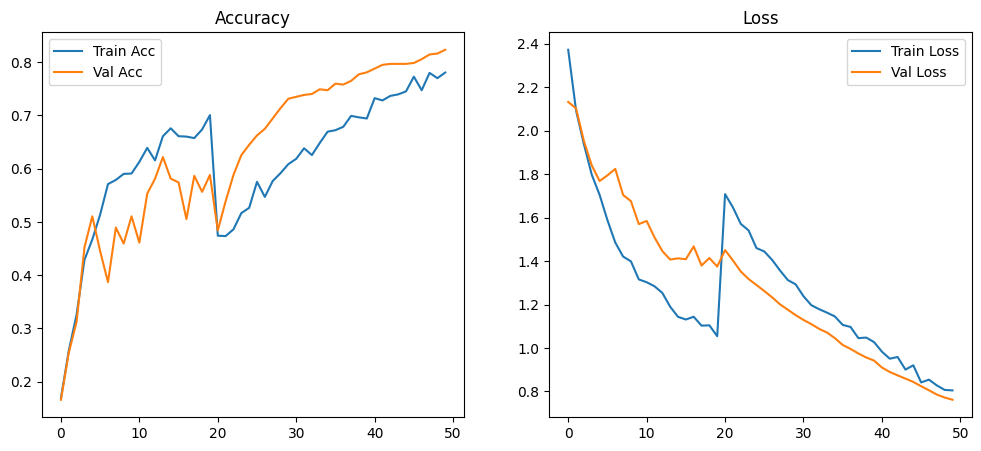

In [10]:
# Combine histories
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()



In [11]:
model.save("/content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5")


In [12]:
img_path = "/content/drive/MyDrive/celebrity_face_project/processed/test/Tony_Blair/Tony_Blair_0045.jpg"


In [13]:
import os
os.path.exists(img_path)


True

In [15]:
!pip install -q tf-keras-vis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.7 MB/s eta 0:00:00


In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

best_model = load_model(
    "/content/drive/MyDrive/celebrity_face_project/models/efficientnet_best.h5"
)


In [17]:
def show_gradcam(img_path, model, class_indices, layer_name="top_conv"):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_class = np.argmax(preds)

    gradcam = Gradcam(model, clone=False)
    cam = gradcam(
        score=lambda output: output[:, pred_class],
        seed_input=img_array,
        penultimate_layer=layer_name
    )
    cam = normalize(cam)

    # class index → name
    idx_to_class = {v: k for k, v in class_indices.items()}
    pred_name = idx_to_class[pred_class]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(cam[0], cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title(f"Grad-CAM: {pred_name} ({preds[0][pred_class]:.2f})")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


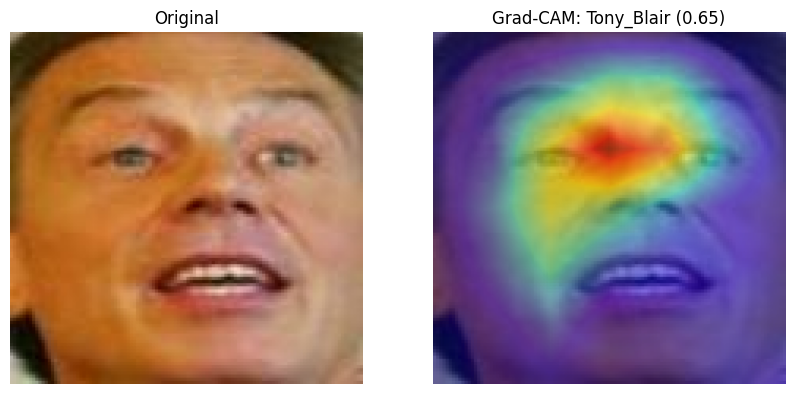

In [20]:
img_path = "/content/drive/MyDrive/celebrity_face_project/processed/test/Tony_Blair/Tony_Blair_0045.jpg"

show_gradcam(
    img_path,
    best_model,
    train_gen.class_indices
)
